# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(26, 26)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [8]:
buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [9]:
columns = ["tick", "seller", "buyer", "product", "amount", "price"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

# Transactions

## Market Overview

In [11]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,23697.0,3.244594e+05
1,25597.0,2.804345e+05
2,58738.0,9.452119e+05
3,30238.0,1.711721e+05
4,23691.0,5.385452e+05
5,25582.0,2.889572e+05
6,58726.0,5.468545e+06
7,30220.0,2.366647e+05
8,3418.0,9.634340e+05


Text(0.5, 1.0, 'transaction count by tick')

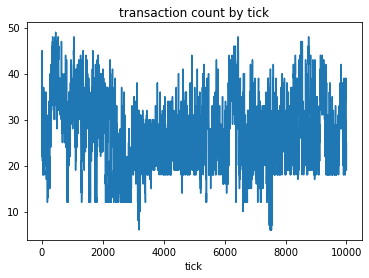

In [12]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

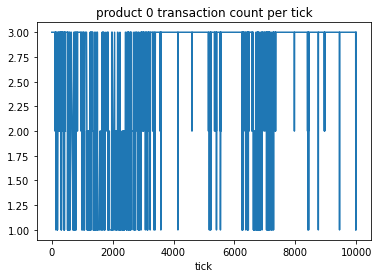

In [13]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

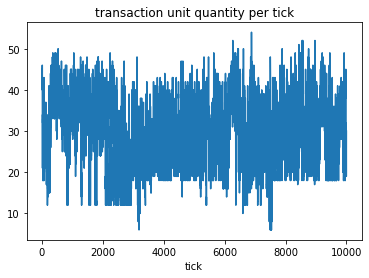

In [14]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

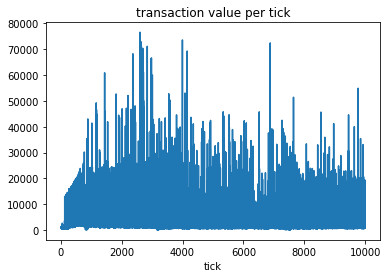

In [15]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

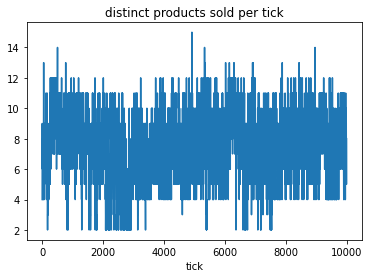

In [16]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

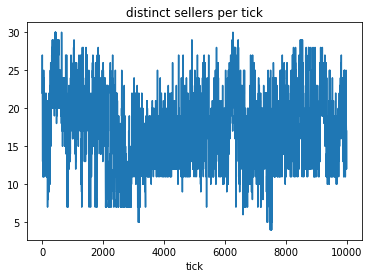

In [17]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

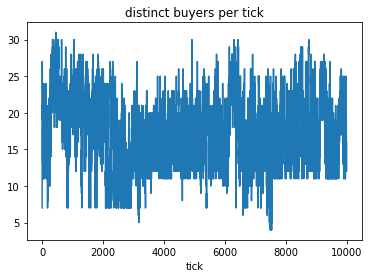

In [18]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [19]:
transaction_df["seller"].nunique()

87

In [20]:
transaction_df["buyer"].nunique()

86

In [21]:
transaction_df["product"].nunique()

23

<AxesSubplot:>

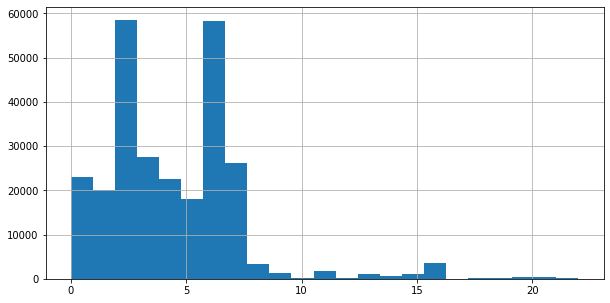

In [22]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

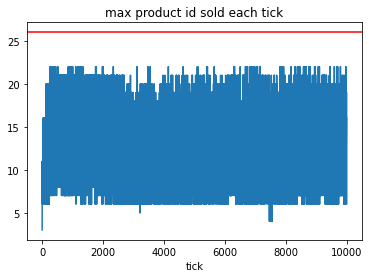

In [23]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [24]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

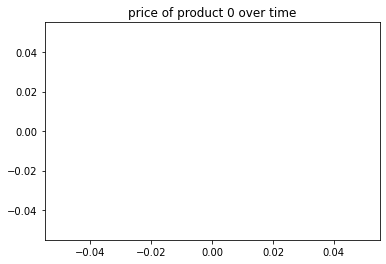

In [25]:
transaction_df[transaction_df["seller"] == 0]["price"].plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 2 over time')

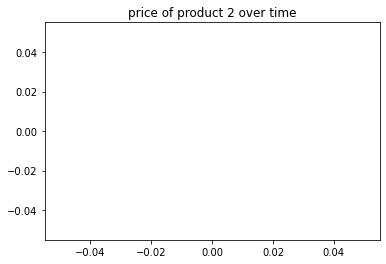

In [26]:
transaction_df[transaction_df["seller"] == 2]["price"].plot()
plt.title("price of product 2 over time")

Text(0.5, 1.0, 'price of product 6 over time')

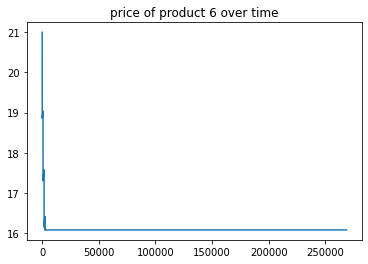

In [27]:
transaction_df[transaction_df["seller"] == 6]["price"].plot()
plt.title("price of product 6 over time")

<AxesSubplot:>

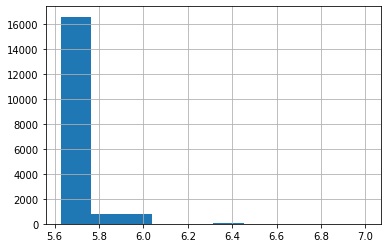

In [28]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

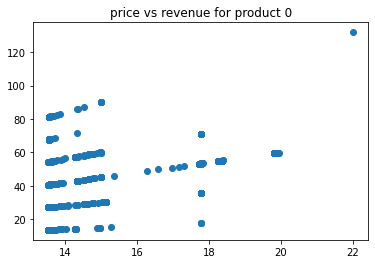

In [29]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

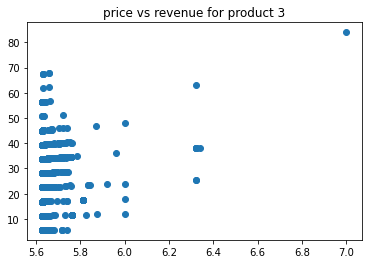

In [30]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [31]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,seller,buyer,product,amount,price,value
0,2,4,0,0,2.0,22.000000,44.000000
1,2,36,0,0,2.0,22.000000,44.000000
2,2,52,0,0,2.0,22.000000,44.000000
22,3,4,0,0,1.0,19.812028,19.812028
23,3,36,0,0,1.0,19.812028,19.812028
...,...,...,...,...,...,...,...
268681,9999,52,49,0,1.0,13.539611,13.539611
268682,9999,4,49,0,1.0,13.538779,13.538779
268700,10000,36,0,0,1.0,13.550220,13.550220
268703,10000,52,0,0,1.0,13.539611,13.539611


## Transaction Graph

In [32]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,0,4,5213.0
1,0,36,5320.0
2,0,52,5335.0
3,1,5,2352.0
4,1,27,2393.0
...,...,...,...
742,98,63,258.0
743,98,65,53.0
744,98,71,486.0
745,98,73,32.0


In [33]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [34]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [35]:
G = nx.relabel_nodes(G, labels)

In [36]:
nx.is_directed_acyclic_graph(G)

True

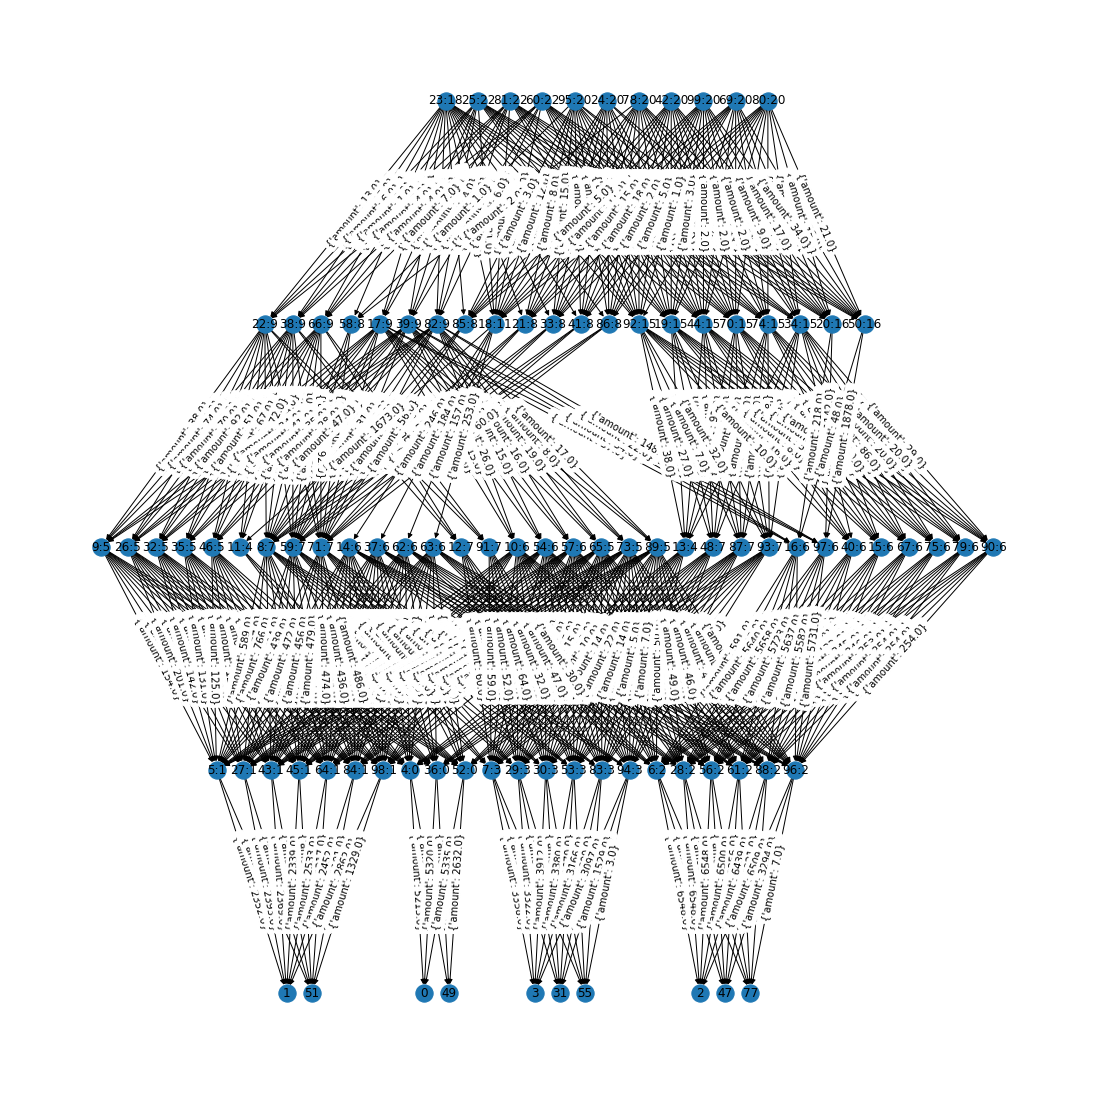

In [37]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

# Balance

In [38]:
balance_df = econ_sim.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [39]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,9.646231e+02
1,0,7.410925e+02
2,0,9.384545e+02
3,0,2.937179e+02
4,0,1.300000e+03
...,...,...
95,0,1.117728e+09
96,0,1.650000e+03
97,0,3.060000e+04


In [40]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,10000,3.439058e+03
1,10000,1.603831e+03
2,10000,1.939542e+05
3,10000,9.506828e+02
4,10000,7.172178e+04
...,...,...
95,10000,1.116512e+09
96,10000,7.516332e+05
97,10000,2.130215e+06


In [41]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [42]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].sparse.to_dense().describe()

count    1.000000e+02
mean     8.066904e+07
std      2.864277e+08
min      2.937179e+02
25%      1.400000e+03
50%      2.467500e+04
75%      1.819625e+05
max      1.117728e+09
Name: balance, dtype: float64

In [43]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].sparse.to_dense().describe()

count    1.000000e+02
mean     8.074234e+07
std      2.860153e+08
min      2.937179e+02
25%      1.156259e+04
50%      1.270880e+05
75%      6.889577e+05
max      1.116512e+09
Name: balance, dtype: float64

In [44]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

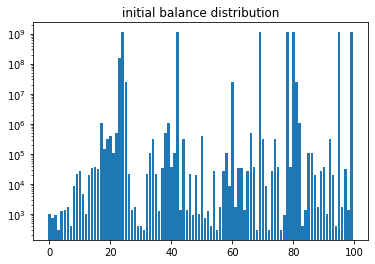

In [45]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

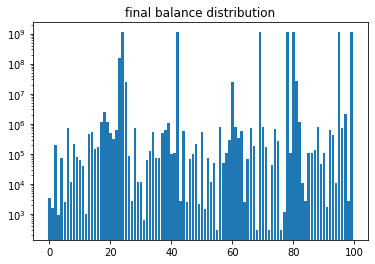

In [46]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [47]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0     2.474435e+03
1     8.627387e+02
2     1.930158e+05
3     6.569650e+02
4     7.042178e+04
          ...     
95   -1.215973e+06
96    7.499832e+05
97    2.099615e+06
98    1.391540e+03
99   -1.381802e+06
Name: balance, Length: 100, dtype: Sparse[float64, 0.0]

In [48]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0     3.439058e+03
1     1.603831e+03
2     1.939542e+05
3     9.506828e+02
4     7.172178e+04
          ...     
95    1.116512e+09
96    7.516332e+05
97    2.130215e+06
98    2.791540e+03
99    1.116346e+09
Name: balance, Length: 100, dtype: Sparse[float64, 0]

In [49]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
1000000,0,10000,3.439058e+03
1000001,1,10000,1.603831e+03
1000002,2,10000,1.939542e+05
1000003,3,10000,9.506828e+02
1000004,4,10000,7.172178e+04
1000005,5,10000,2.549401e+03
1000006,6,10000,7.508763e+05
1000007,7,10000,1.137636e+04
1000008,8,10000,2.098802e+05
1000009,9,10000,7.581518e+04


<AxesSubplot:>

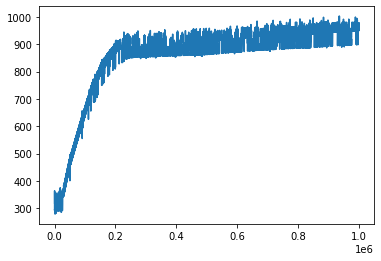

In [50]:
balance_df[balance_df["agent"] == 3]["balance"].plot()

In [51]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [52]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,3.565183
1,2.164144
2,206.674094
3,3.236721
4,55.170601
...,...
95,0.998912
96,455.535284
97,69.614857


# Inventory

In [53]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = econ_sim.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

## Last Tick Inventory

In [54]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,16,17,18,19,20,21,22,23,24,25
1000000,0,10000,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000001,1,10000,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000002,2,10000,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,3,10000,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000004,4,10000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000095,95,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,19.0,37.0,36.0,0.0,0.0,0.0,0.0
1000096,96,10000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000097,97,10000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000098,98,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [55]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [56]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,19.0,37.0,36.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [57]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-511.0,-716.0,-707.0,-671.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [58]:
agent_id = 21
inv_s = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent").loc[agent_id].drop("tick")
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,NaN
8,0.0,6.0,6.0,-6.0,0.0
9,0.0,0.0,0.0,0.0,NaN


In [59]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == balance_df["tick"].max())]

,agent,tick,balance
1000021,21,10000,304943.206527


In [60]:
buy_budget_df[(buy_budget_df["tick"] == buy_budget_df["tick"].max()) & (buy_budget_df["agent"] == agent_id)].T

,1000021
agent,21.000000
tick,10000.000000
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [61]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].sparse.to_dense().describe()

count    10001.000000
mean         1.644236
std          0.747274
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: 21, dtype: float64

# Buy and Sell Prices

In [62]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     1.353769e+01
1     1.089075e+01
2     1.115455e+01
3     5.628213e+00
4     1.357022e+01
5     1.089456e+01
6     2.007876e+01
7     5.628516e+00
8     9.342032e+01
9     2.254271e+02
10    5.379405e+02
11    4.101697e+01
12    1.129145e+01
13    5.056476e+02
14    7.734912e+02
15    5.976403e+02
16    6.575202e+02
17    2.258073e+04
18    9.479247e+03
19    1.613528e+04
20    9.142436e+03
21    1.144850e+03
22    6.270330e+03
23    7.002185e+06
24    6.197864e+07
25    1.382010e+06
dtype: float64

## Market Analysis for one Good

In [63]:
product_id = 18
min_ticks = 0
max_ticks = np.inf

df1 = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))].groupby("tick")[product_id].min().sparse.to_dense().to_frame().reset_index()
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks, max_ticks))].groupby("tick")[product_id].min().sparse.to_dense().to_frame().reset_index()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id].sparse.to_dense()
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id].sparse.to_dense()

buyer_df = buy_budget_df[buy_budget_df[product_id] > 0][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


2.0


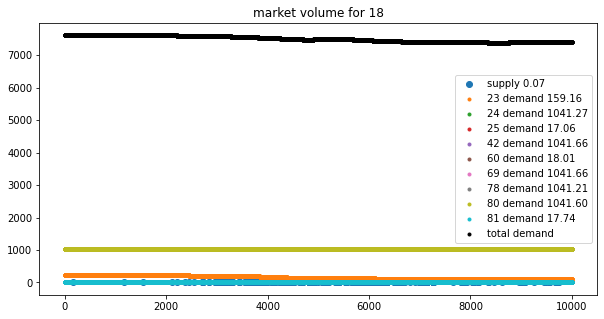

In [64]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

Text(0.5, 1.0, 'price chart for 18')

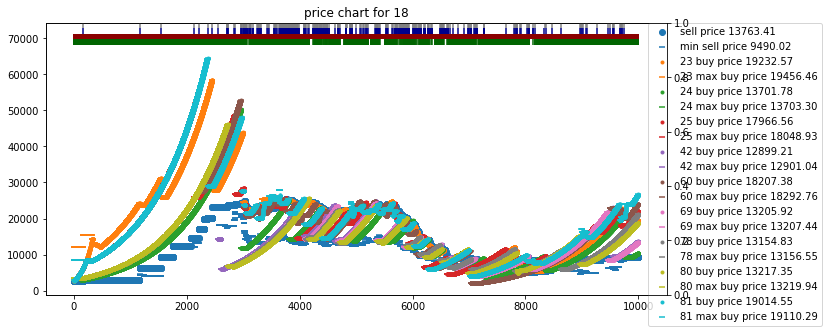

In [65]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1["tick"], df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(dfms["tick"], dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
ax2.vlines((buyer_df.groupby("tick")["units"].sum() > 0).index, ymin=0.94, ymax=0.96, color="darkred")
ax2.vlines(df1[(df2.groupby("tick")[product_id].max() - df1[product_id])>0].index, ymin=0.92, ymax=0.94, color="darkgreen")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



(0.0, 1172438117.5100405)

<Figure size 432x288 with 0 Axes>

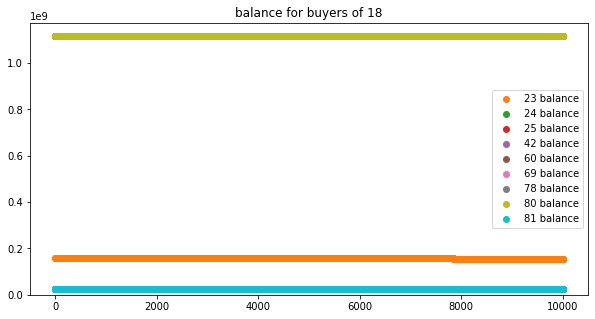

In [66]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [67]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["amount"].sum()

buyer
18    278.0
Name: amount, dtype: float64

In [68]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
18,269.0,5221.855019,1870.246812,165.0,3820.0,4904.0,6267.0,9751.0


In [69]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
18,269.0,20521.578767,6770.709334,4629.364355,15426.929567,22649.14677,24262.583246,42246.766855


### Buy/Sell Price Investigation

In [70]:
df1[product_id].describe()

count    10001.000000
mean     13763.412188
std       7527.379463
min       2835.000000
25%       8494.161231
50%       9479.247417
75%      22434.767708
max      25409.201559
Name: 18, dtype: float64

In [71]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
23,10001.0,19232.570623,10244.365561,2835.00000,10117.902749,20118.908202,24158.895037,58462.035841
24,10001.0,13701.780192,8418.466892,2835.00000,7633.764188,12252.340407,17585.180776,50231.342880
25,10001.0,17966.561259,9657.903236,2835.00000,9206.836230,17608.057371,22792.047270,50271.201558
42,10001.0,12899.211581,6736.610512,2835.00000,7597.884638,11794.508966,16825.155527,38780.313550
60,10001.0,18207.384487,11141.608476,2053.12769,9167.057317,18853.286166,22923.378348,54880.225215
69,10001.0,13205.919979,7595.642345,2835.00000,7647.019971,11716.144405,16917.318969,45596.537841
78,10001.0,13154.829821,7529.129585,2835.00000,7587.319621,11302.737373,16667.062039,45824.976952
80,10001.0,13217.347580,7519.785790,2835.00000,8026.111870,11563.538369,16416.771261,46146.715720
81,10001.0,19014.546983,11431.573943,2835.00000,9560.831533,18326.753923,23528.737434,64374.615041


In [72]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

17216.196836345007

In [73]:
(df2.groupby("tick")[product_id].max() - df1.set_index("tick")[product_id]).describe()

count    10001.000000
mean      7767.584012
std      10379.364387
min      -2467.087900
25%        241.034367
50%       2132.406383
75%      13608.013526
max      44255.696372
Name: 18, dtype: float64

In [74]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

17474.320849303625

In [75]:
(dfmb.groupby("tick")[product_id].max() - dfms.set_index("tick")[product_id]).describe()

count    10001.000000
mean     12277.323620
std       8705.574792
min        398.898449
25%       6282.413283
50%      10059.078527
75%      14719.316302
max      44323.078771
Name: 18, dtype: float64

In [76]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
18,2643.000000,3554.406781,2835.000000,2642.557988,192.000000
118,2404.602624,2835.000000,2835.000000,2643.000000,430.397376
218,2407.392624,2835.000000,2835.000000,2643.000000,427.607376
318,2410.196574,2835.000000,2835.000000,2643.000000,424.803426
418,2413.014544,2835.000000,2835.000000,2643.000000,421.985456
...,...,...,...,...,...
999618,15189.415436,15189.448290,9479.247417,9221.123404,-5710.168019
999718,15189.415436,15189.448290,9479.247417,9221.123404,-5710.168019
999818,15189.415436,15189.448290,9479.247417,9221.123404,-5710.168019
999918,15189.415436,15189.448290,9479.247417,9221.123404,-5710.168019


## Larger Scale Market Analysis

In [77]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

In [78]:
demand_units_df[0].groupby("tick").sum()

tick
0        0.0
1        6.0
2        6.0
3        3.0
4        3.0
        ... 
9996     3.0
9997     3.0
9998     3.0
9999     3.0
10000    3.0
Name: 0, Length: 10001, dtype: Sparse[float64, nan]

In [79]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean()
demand_units_mean - supply_units_mean

0          -17.505349
1          -21.472853
2          -18.432857
3          -57.191481
4           53.445955
5           86.948205
6          158.768823
7           61.408159
8           59.629437
9           51.637536
10          18.209379
11          16.656634
12           4.157784
13          22.706529
14           1.397760
15          22.412959
16          38.222578
17          36.725927
18        7501.056394
19       10351.557344
20       10247.028597
21        9810.827417
22          94.388661
23           0.000000
24           0.000000
25          -0.000600
agent             NaN
dtype: float64

In [ ]:
#(demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean()
(((demand_units_df.groupby("tick").sum()) ** 2).mean() - demand_units_mean)/demand_units_mean

In [ ]:
#(supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()
(((supply_units_df.groupby("tick").sum()) ** 2).mean() - supply_units_mean)/supply_units_mean

# Profit Analysis

In [ ]:
revenue = transaction_df.groupby("seller")["value"].sum()
costs = transaction_df.groupby("buyer")["value"].sum()

In [ ]:
costs

In [ ]:
revenue

In [ ]:
(revenue-costs)

In [ ]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

# Production Efficiency

In [ ]:
production_efficiency_df = econ_sim.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")